In [1]:
using Pkg; _print_conf()
# pkg"activate ."

Base.PROGRAM_FILE=/home/tb/opt/envs/py39/__pkgs__/julia-deps/.julia/packages/IJulia/e8kqU/src/kernel.jl
Base.ARGS=["/home/tb/.local/share/jupyter/runtime/kernel-ccc544f4-4433-4f6e-a4f3-3de78d3d6f33.json"]
Base.C_NULL=Ptr{Nothing} @0x0000000000000000
Base.VERSION=1.6.1
Base.DEPOT_PATH=["/home/tb/opt/envs/py39/__pkgs__/julia-deps/.julia", "/home/tb/opt/envs/py39/__pkgs__/julia-deps/local/share/julia", "/home/tb/opt/envs/py39/__pkgs__/julia-deps/share/julia"]
Base.LOAD_PATH=["/home/tb/cea/postdoc/julia/__load__", "@", "@v#.#", "@stdlib"]
Sys.BINDIR=/home/tb/opt/envs/py39/__pkgs__/julia-deps/bin
Sys.STDLIB=/home/tb/opt/envs/py39/__pkgs__/julia-deps/share/julia/stdlib/v1.6
Sys.CPU_THREADS=32
Sys.CPU_NAME=sandybridge
Sys.WORD_SIZE=64
Sys.ARCH=x86_64
Sys.MACHINE=x86_64-unknown-linux-gnu
Sys.KERNEL=Linux
Sys.JIT=ORCJIT


In [2]:
using RegionTrees
using StaticArrays: SVector
using Plots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


In [3]:
# The most basic data type in this package is a Cell,
# which can represent a node or a leaf in the tree.
# Let's build a Cell which spans from [0, 0] and has
# length 1 along each axis
root = Cell(SVector(0., 0), SVector(1., 1))

Cell: HyperRectangle{2, Float64}([0.0, 0.0], [1.0, 1.0])

In [4]:
# The Cell type is used for leaves and nodes. We can check
# if root is a leaf with isleaf() 
isleaf(root)

true

In [5]:
# Now let's refine the cell:
split!(root)

Cell: HyperRectangle{2, Float64}([0.0, 0.0], [1.0, 1.0])

In [6]:
# The cell is no longer a leaf because it now has children:
isleaf(root)

false

In [7]:
@assert length(children(root)) == 4

In [8]:
# Each child now represents one quarter of the region
# spanned by root. We can access children using the
# indexing notation:
root[1,1]

Cell: HyperRectangle{2, Float64}([0.0, 0.0], [0.5, 0.5])

In [9]:
# or with the children() function:
children(root)[1,1]

Cell: HyperRectangle{2, Float64}([0.0, 0.0], [0.5, 0.5])

In [10]:
# We can further refine one of the children:
split!(root[1,1])

Cell: HyperRectangle{2, Float64}([0.0, 0.0], [0.5, 0.5])

In [11]:
# Now there are more children:
root[1,1][1,1]

Cell: HyperRectangle{2, Float64}([0.0, 0.0], [0.25, 0.25])

In [12]:
root[1,1][1,2]

Cell: HyperRectangle{2, Float64}([0.0, 0.25], [0.25, 0.25])

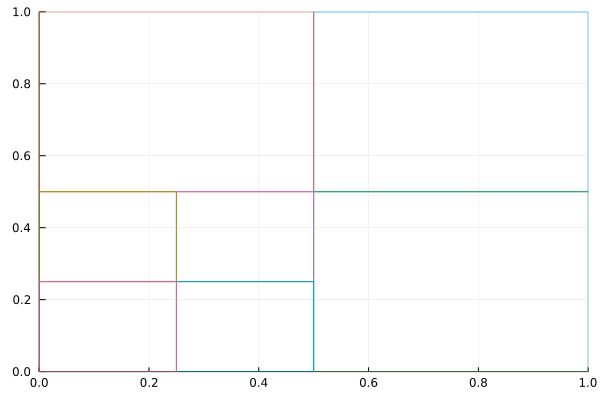

In [13]:
# Let's plot the cells we have so far
plt = plot(xlim=(0, 1), ylim=(0, 1), legend=nothing)
for leaf in allleaves(root)
    v = hcat(collect(vertices(leaf.boundary))...)
    plot!(plt, v[1,[1,2,4,3,1]], v[2,[1,2,4,3,1]])
end
plt

In [14]:
# Now, so far just splitting cells is not super useful. Let's
# try adding some data to each cell:

In [15]:
cell = Cell(SVector(0., 0), SVector(1., 1), "A")

Cell: HyperRectangle{2, Float64}([0.0, 0.0], [1.0, 1.0])

In [16]:
# We now have a new cell, with a data payload consisting of
# a string:
cell.data

"A"

In [17]:
# The type of the data payload (String) is now part of the cell's
# type, which lets Julia efficiently handle our cell:
typeof(cell)

Cell{String, 2, Float64, 4}

In [18]:
# By default, `split!(cell)` just copies the cell's data into
# each of its children. That's probably not what we want here.
# Instead, we can pass in new data for each child when we call
# split:
split!(cell, ["B", "C", "D", "E"])

Cell: HyperRectangle{2, Float64}([0.0, 0.0], [1.0, 1.0])

In [19]:
cell[1,1].data

"B"

In [20]:
cell[2,1].data

"C"

In [22]:
# If managing a list of child data is inconvenient, you can 
# instead pass in a function to generate the child data. That
# function will be called with two inputs: the cell being split
# and the indices of the child being created:

c = Cell(SVector(0., 0), SVector(1., 1), "root")

# Let's make a simple data generator that just tacks on the 
# indices from the root of the tree:
function getdata(cell, child_indices)
    "$(cell.data) child $(child_indices)"
end

split!(c, getdata)
split!(c[1,1], getdata)
split!(c[1,2], getdata)
split!(c[1,2][2,2], getdata)

Cell: HyperRectangle{2, Float64}([0.25, 0.75], [0.25, 0.25])

In [23]:
c[1,2][2,2][1,1].data

"root child (1, 2) child (2, 2) child (1, 1)"

In [24]:
# Finally, there is a higher-level abstraction than this
# for automatically splitting cells and populating their data. 
# The concept is based around adaptive sampling and is implemented
# through the "refinery" concept. 
#
# A refinery is a type which inherits from AbstractRefinery and 
# implements two methods:
#
# needs_refinement(refinery, cell::Cell): 
#     returns true if the cell should be split
# 
# refine_data(refinery, cell::Cell, indices): 
#     returns the new data for the cell's child with the
#     given indices
#
# You may want to use child_boundary(cell, indices) to get the bounding
# box corresponding to the child cell for which you are generating data.

# Let's create a trivial example that will refine each cell until
# its width is less than a given tolerance:
import RegionTrees: AbstractRefinery, needs_refinement, refine_data

struct MyRefinery <: AbstractRefinery
    tolerance::Float64
end

# These two methods are all we need to implement
function needs_refinement(r::MyRefinery, cell)
    maximum(cell.boundary.widths) > r.tolerance
end
function refine_data(r::MyRefinery, cell::Cell, indices)
    boundary = child_boundary(cell, indices)
    "child with widths: $(boundary.widths)"
end

# Now we can use our refinery to create the entire tree, with
# all cells split automatically:
r = MyRefinery(0.05)
root = Cell(SVector(0., 0), SVector(1., 1), "root")
adaptivesampling!(root, r)

Cell: HyperRectangle{2, Float64}([0.0, 0.0], [1.0, 1.0])

In [25]:
root[1,1][1,1][1,1][1,1][1,1].data

"child with widths: [0.03125, 0.03125]"

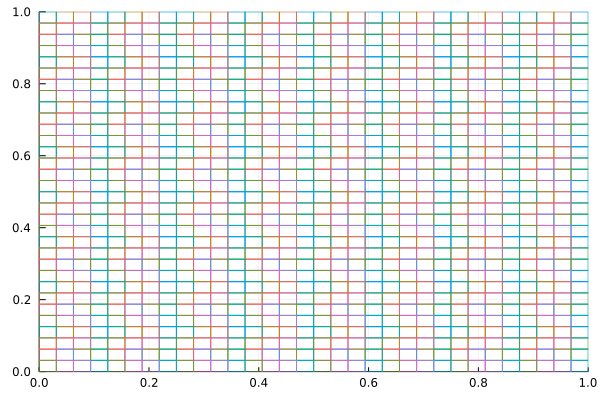

In [26]:
plt = plot(xlim=(0, 1), ylim=(0, 1), legend=nothing)
for leaf in allleaves(root)
    v = hcat(collect(vertices(leaf.boundary))...)
    plot!(plt, v[1,[1,2,4,3,1]], v[2,[1,2,4,3,1]])
end
plt